##**Datasets & Libaries**

In [1]:
# --- STEP 1: Update Pustaka untuk mengatasi ModuleNotFoundError ---
print("⏳ Memperbarui pustaka scikit-learn dan imbalanced-learn...")

# Perbarui scikit-learn (Wajib: minimal v1.2)
!pip install --upgrade scikit-learn

# Perbarui imbalanced-learn (Disarankan: untuk memastikan kompatibilitas)
!pip install --upgrade imbalanced-learn

# Pastikan Sastrawi juga ada
!pip install Sastrawi

print("\n✅ Instalasi selesai. Anda mungkin perlu menjalankan kembali KESELURUHAN Notebook.")

⏳ Memperbarui pustaka scikit-learn dan imbalanced-learn...

✅ Instalasi selesai. Anda mungkin perlu menjalankan kembali KESELURUHAN Notebook.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Library NLP
import nltk

# Menghapus 'punkt_tab' karena tidak standar, NLTK akan menggunakan 'punkt' di bawah.
# from nltk.corpus import stopwords 
# from nltk.tokenize import word_tokenize 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from imblearn.over_sampling import SMOTE # Ini sekarang akan bekerja

# Library Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- PENTING: Perbaiki NLTK LookupError ---
print("⏳ Memastikan NLTK Resources tersedia...")
try:
    # Mengunduh resource yang diperlukan untuk tokenisasi dan stopwords
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    
    # Import fungsi setelah download
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    print("✅ NLTK Resources berhasil diunduh.")
except Exception as e:
    print(f"⚠️ Gagal mengunduh NLTK resources: {e}")

# --- Inisialisasi Sumber Daya NLP Lanjutan ---
try:
    LIST_STOPWORDS = set(stopwords.words('indonesian'))
    STEMMER_FACTORY = StemmerFactory()
    STEMMER = STEMMER_FACTORY.create_stemmer()
    print("✅ Stopwords dan Stemmer Sastrawi siap.")
except Exception as e:
    print(f"❌ Error inisialisasi Sastrawi: {e}")
    LIST_STOPWORDS = set()
    STEMMER = None

⏳ Memastikan NLTK Resources tersedia...
✅ NLTK Resources berhasil diunduh.
✅ Stopwords dan Stemmer Sastrawi siap.


In [3]:
df = pd.read_csv('/kaggle/input/spam-dataset/spam.csv', on_bad_lines='skip')

In [4]:
df

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."
...,...,...
2631,ham,Pengingat halo semuanya: Vince telah meminta s...
2632,ham,Re: Argentina Power & Gas Market Modeling Oke ...
2633,ham,"Re: Program Enron / Stanford Stinson, hebat! S..."
2634,ham,"Persetujuan untuk peninjau Roberts JR, Michael..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2636 non-null   object
 1   Pesan     2636 non-null   object
dtypes: object(2)
memory usage: 41.3+ KB


In [6]:
df['Kategori'].value_counts()

Kategori
spam    1368
ham     1268
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribusi Jumlah Perbandingan Kategori Label')

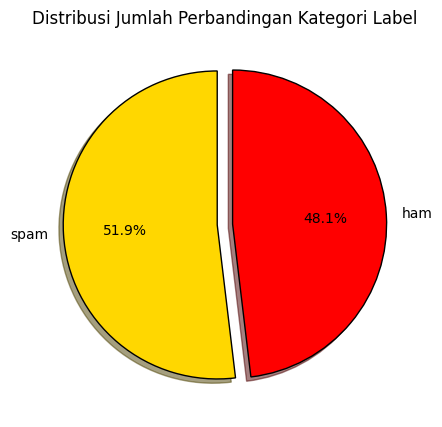

In [7]:
fig = plt.figure(figsize=(5,5))
colors = ("gold", "red")
wp = {'linewidth':1, 'edgecolor':"black"}
tags = df['Kategori'].value_counts()
explode = (0.05, 0.05)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribusi Jumlah Perbandingan Kategori Label')

##**Fungsi Preprocessing**

In [8]:
def caseFolding_and_cleaning(text):
    """Mengubah ke lowercase, menghapus pola URL/HTML/path noise, alamat email, dan tanda baca."""
    text = str(text).lower()
    text = re.sub(r"https?:\/\/\S+|www\.\S+|(\/.*?\?)|(<.*?>)", " ", text)
    text = re.sub(r'\S+@\S+', 'EMAIL_ADDRESS', text)
    translator = str.maketrans('', '', string.punctuation.replace('@', '').replace('.', ''))
    text = text.translate(translator)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def advanced_normalization(text):
    """Melakukan decoding, menangani karakter berulang, mengganti angka, tokenisasi, stopword removal, dan stemming."""
    text = text.replace('%20', ' ').replace('%3c', '<').replace('%3e', '>').replace('%2f', '/')
    text = text.replace('&#x2f;', '/').replace('&#x2e;', '.')
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\d+', 'NUM', text)

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in LIST_STOPWORDS]

    if STEMMER:
        tokens = [STEMMER.stem(word) for word in tokens]

    return ' '.join(tokens)

def full_preprocessing(text):
    """Menjalankan keseluruhan alur preprocessing."""
    text = caseFolding_and_cleaning(text)
    text = advanced_normalization(text)
    return text

##**Pipeline Utama: Pemrosesan Data, Pelatihan, dan Evaluasi**


A. MEMUAT DATASET
✅ Data berhasil dimuat. Total baris: 2636

B. PROSES PREPROCESSING DAN NORMALISASI
Processing Index 0...
Processing Index 500...
Processing Index 1000...
Processing Index 1500...
Processing Index 2000...
Processing Index 2500...
--- Contoh Data yang Sudah Dinormalisasi ---
                                        Pesan_mentah  \
0  Secara alami tak tertahankan identitas perusah...   
1  Fanny Gunslinger Perdagangan Saham adalah Merr...   
2  Rumah -rumah baru yang luar biasa menjadi muda...   
3  4 Permintaan Khusus Pencetakan Warna Informasi...   
4  Jangan punya uang, dapatkan CD perangkat lunak...   

                                    pesan_normalized kategori  
0  alami tahan identitas usaha sulit usaha pasar ...     spam  
1  fanny gunslinger dagang saham merrill muzo col...     spam  
2  rumah rumah mudah milik rumah tuju pinjam ruma...     spam  
3  num minta khusus cetak warna informasi tambah ...     spam  
4  uang dapat cd perangkat lunak kompatibilitas p.

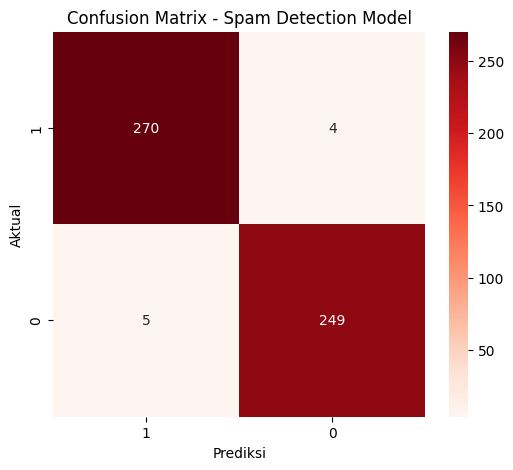

In [10]:
def run_spam_detection_pipeline(file_path):
    """Menjalankan seluruh pipeline dari data hingga evaluasi."""

    # --- A. MEMUAT DATASET ---
    print("\n" + "="*50)
    print("A. MEMUAT DATASET")
    print("="*50)

    try:
        # PENTING: Sesuaikan fungsi pembacaan data jika file Anda bukan CSV (misal: read_excel)
        df = pd.read_csv(file_path)

        # Membersihkan baris dengan nilai yang hilang (NaN) jika ada
        df.dropna(subset=['Kategori', 'Pesan'], inplace=True)

        # Memastikan hanya kolom yang diperlukan yang digunakan
        df = df[['Kategori', 'Pesan']].copy()

        print(f"✅ Data berhasil dimuat. Total baris: {len(df)}")

    except FileNotFoundError:
        print(f"❌ ERROR: File dataset '{file_path}' tidak ditemukan.")
        return

    # --- B. PREPROCESSING & NORMALISASI ---
    print("\n" + "="*50)
    print("B. PROSES PREPROCESSING DAN NORMALISASI")
    print("="*50)

    Dataset_Normalized = list()

    for index, row in df.iterrows():
        if index % 500 == 0:
            print(f'Processing Index {index}...')

        text_mentah = row['Pesan']

        # Panggil fungsi full_preprocessing yang sudah disempurnakan
        pesan_normalized = full_preprocessing(text_mentah)

        Dataset_Normalized.append({
            "Pesan_mentah" : text_mentah,
            "pesan_normalized" : pesan_normalized,
            "kategori" : row['Kategori']
        })

    df_normalized = pd.DataFrame(Dataset_Normalized)

    print("--- Contoh Data yang Sudah Dinormalisasi ---")
    print(df_normalized[['Pesan_mentah', 'pesan_normalized', 'kategori']].head())

    # --- C. PEMBAGIAN DATA ---

    X = df_normalized['pesan_normalized'] # Feature: teks bersih
    y = df_normalized['kategori'].map({'ham': 0, 'spam': 1}) # Target: label numerik (0=ham, 1=spam)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nUkuran Data Latih: {len(X_train)} | Ukuran Data Uji: {len(X_test)}")

    # --- D. EKSTRAKSI FITUR (TF-IDF) ---
    print("\n" + "="*50)
    print("D. EKSTRAKSI FITUR (TF-IDF)")
    print("="*50)

    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2), # Menggunakan unigram dan bigram
        min_df=5           # Kata harus muncul di minimal 5 dokumen
    )
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # --- E. PENYEIMBANGAN DATA MENGGUNAKAN SMOTE ---
    print("\n" + "="*50)
    print("D.5. PENYEIMBANGAN DATA (SMOTE)")
    print("="*50)
    
    # 1. Sebelum SMOTE
    print(f"Proporsi Label di Data Latih (Sebelum SMOTE):\n{y_train.value_counts()}")
    
    # 2. Inisialisasi SMOTE
    smote = SMOTE(random_state=42)
    
    # 3. Aplikasikan SMOTE hanya pada data latih
    # Ini akan membuat sampel sintetis untuk kelas minoritas (SPAM, label 1)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)
    
    # 4. Setelah SMOTE
    print(f"\nProporsi Label di Data Latih (Setelah SMOTE):\n{y_train_balanced.value_counts()}")
    print(f"Jumlah sampel latih baru: {X_train_balanced.shape[0]}")
    print("✅ Penyeimbangan data selesai.")

    print(f"Jumlah Fitur (Kata Unik) yang diekstrak: {len(vectorizer.get_feature_names_out())}")

    # --- F. PELATIHAN MODEL ---
    print("\n" + "="*50)
    print("E. PELATIHAN MODEL (Multinomial Naive Bayes)")
    print("="*50)

    model = MultinomialNB()
    model.fit(X_train_balanced, y_train_balanced)
    print("✅ Pelatihan Model Selesai.")

    # --- G. EVALUASI MODEL ---
    print("\n" + "="*50)
    print("F. EVALUASI MODEL")
    print("="*50)

    y_pred = model.predict(X_test_vec)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"⭐ Akurasi Model: {accuracy*100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=['Aktual Ham (0)', 'Aktual Spam (1)'], columns=['Prediksi Ham (0)', 'Prediksi Spam (1)']))

    print("\nClassification Report (Precision, Recall, F1-Score):")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=y.unique(), yticklabels=y.unique())
    plt.title('Confusion Matrix - Spam Detection Model') # Corrected line
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()

    return vectorizer, model

# --- Jalankan Pipeline dengan Nama File Dataset Anda ---

if __name__ == "__main__":
    # GANTI 'nama_file_dataset_anda.csv' dengan path/nama file Anda yang sebenarnya
    FILE_DATASET = '/kaggle/input/spam-dataset/spam.csv'
    # Capture the returned vectorizer and model
    global vectorizer, model
    vectorizer, model = run_spam_detection_pipeline(FILE_DATASET)

**Uji Coba Data Baru**

In [11]:
# --- H. UJI COBA PADA DATA BARU (INFERENSI) ---
print("\n" + "="*50)
print("G. UJI COBA PADA DATA BARU")
print("="*50)

# 1. Definisikan teks email baru yang ingin Anda uji
# Anda bisa mengganti teks ini dengan input dari user atau file
new_email_list = [
    "Selamat! Anda terpilih untuk hadiah mobil mewah. Klik link ini untuk klaim sekarang juga.",
    "Konfirmasi pemesanan tiket pesawat Anda. Mohon siapkan kode booking saat check-in. Terima kasih.",
    "Mohon cek laporan bulanan yang baru saja saya kirimkan via email. Terima kasih."
]

print(f"📧 Teks 1: '{new_email_list[0]}'")
print(f"📧 Teks 2: '{new_email_list[1]}'")
print(f"📧 Teks 3: '{new_email_list[2]}'")

# 2. Preprocess Teks Baru
# Terapkan fungsi preprocessing yang sama persis seperti saat training!
processed_new_emails = [full_preprocessing(e) for e in new_email_list]

print("\n⚙️ Teks Setelah Preprocessing:")
print(processed_new_emails)

# 3. Vectorization (Transformasi Fitur)
# PENTING: Gunakan objek 'vectorizer' yang sudah di-fit pada data training.
# JANGAN gunakan .fit_transform(), hanya .transform()!
# Ensure vectorizer is available globally
if 'vectorizer' not in globals():
    raise NameError("Vectorizer object not found. Please run the training pipeline first.")
new_email_vec = vectorizer.transform(processed_new_emails)

# 4. Prediksi
# Ensure model is available globally
if 'model' not in globals():
    raise NameError("Model object not found. Please run the training pipeline first.")
predictions = model.predict(new_email_vec)

# 5. Output Hasil
label_map = {0: "NON-SPAM (HAM) ✅", 1: "SPAM ❌"}
print("\n--- Hasil Deteksi ---")

for i, pred in enumerate(predictions):
    result = label_map[pred]
    print(f"Email {i+1} ({predictions[i]}): **{result}**")


G. UJI COBA PADA DATA BARU
📧 Teks 1: 'Selamat! Anda terpilih untuk hadiah mobil mewah. Klik link ini untuk klaim sekarang juga.'
📧 Teks 2: 'Konfirmasi pemesanan tiket pesawat Anda. Mohon siapkan kode booking saat check-in. Terima kasih.'
📧 Teks 3: 'Mohon cek laporan bulanan yang baru saja saya kirimkan via email. Terima kasih.'

⚙️ Teks Setelah Preprocessing:
['selamat pilih hadiah mobil mewah  klik link klaim ', 'konfirmasi mesan tiket pesawat  mohon siap kode booking checkin  terima kasih ', 'mohon cek lapor bulan kirim via email  terima kasih ']

--- Hasil Deteksi ---
Email 1 (1): **SPAM ❌**
Email 2 (0): **NON-SPAM (HAM) ✅**
Email 3 (0): **NON-SPAM (HAM) ✅**


**SAVE MODEL**

In [16]:
import joblib
import os

# --- Model dan Vectorizer sudah dilatih ---

# Definisikan nama file yang akan disimpan
MODEL_FILENAME = "spam_model_nb.joblib"
VECTORIZER_FILENAME = "tfidf_vectorizer.joblib"

# 1. Simpan Model Klasifikasi
joblib.dump(model, MODEL_FILENAME)
print(f"✅ Model berhasil disimpan sebagai: {MODEL_FILENAME}")

# 2. Simpan Vectorizer (TF-IDF)
joblib.dump(vectorizer, VECTORIZER_FILENAME)
print(f"✅ Vectorizer berhasil disimpan sebagai: {VECTORIZER_FILENAME}")

✅ Model berhasil disimpan sebagai: spam_model_nb.joblib
✅ Vectorizer berhasil disimpan sebagai: tfidf_vectorizer.joblib


In [17]:
import pickle
import os

# --- Model dan Vectorizer sudah dilatih ---

# Anggap Anda sudah memiliki objek ini dari pelatihan
# model = MultinomialNB() # Contoh model
# vectorizer = TfidfVectorizer() # Contoh vectorizer

# Definisikan nama file yang akan disimpan
MODEL_FILENAME_PKL = "spam_model_nb.pkl" # Ubah ekstensi menjadi .pkl (pickle)
VECTORIZER_FILENAME_PKL = "tfidf_vectorizer.pkl" # Ubah ekstensi menjadi .pkl (pickle)

# 1. Simpan Model Klasifikasi menggunakan pickle
try:
    with open(MODEL_FILENAME_PKL, 'wb') as file:
        pickle.dump(model, file)
    print(f"✅ Model berhasil disimpan sebagai: {MODEL_FILENAME_PKL}")
except NameError:
    print("⚠️ Error: Variabel 'model' belum terdefinisi. Pastikan Anda sudah melatih model Anda.")
except Exception as e:
    print(f"❌ Gagal menyimpan model: {e}")


# 2. Simpan Vectorizer (TF-IDF) menggunakan pickle
try:
    with open(VECTORIZER_FILENAME_PKL, 'wb') as file:
        pickle.dump(vectorizer, file)
    print(f"✅ Vectorizer berhasil disimpan sebagai: {VECTORIZER_FILENAME_PKL}")
except NameError:
    print("⚠️ Error: Variabel 'vectorizer' belum terdefinisi. Pastikan Anda sudah melatih vectorizer Anda.")
except Exception as e:
    print(f"❌ Gagal menyimpan vectorizer: {e}")

✅ Model berhasil disimpan sebagai: spam_model_nb.pkl
✅ Vectorizer berhasil disimpan sebagai: tfidf_vectorizer.pkl
